## Start by copying this into your Google Drive!!

Maastricht_University_logo.svg

# Advanced Natural Language Processing Course - Tutorial Speech Recognition
Author: Gijs Wijngaard




Welcome to the tutorial about speech recognition. In this notebook you will learn how to recognize and classify speech. We will first start with older methods to give you a grasp of the problems we are facing. After that, we will use state-of-the-art transformer techniques to classify speech. We go over Connectionist Temporal Classification, a important scoring function in speech recognition.

---

In this notebook, we will use PyTorch. Using this, we need less code to build the neural networks, while also still achieving high results. We also use TorchAudio, which is PyTorch' audio deep learning framework. This framework helps us deal with audio datasets in PyTorch.

The first step is to **enable GPU**. A GPU is a Graphical Processing Unit, capable of calculating vectors and matrices much faster than CPU units, like the one in your laptop. Since neural networks are basically made out of matrices, we gain serious speed improvements by using GPU's.

We enable the GPU by clicking on *Runtime* in the menu above, then click *Change runtime type* and on the dropdown menu under *Hardware accelerator* we click *GPU*. Then click *Save*. If everything is correct, the below code should return **True**.

In [ ]:
import torch
torch.cuda.is_available()

True

With the command `!nvidia-smi` we can show how fast our GPU is. We see how many GPU's we have, we see which type of GPU we have and we see how much memory it has.

In [ ]:
!nvidia-smi

Fri Dec  2 22:19:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Dataset LibriSpeech 
We now download the dataset LibriSpeech. This dataset has approximately 1000 hours of 16kHz English speech. The data is derived from read audiobooks from the LibriVox project, and has been carefully segmented and aligned.
TorchAudio supports downloading the dataset for us. See the documentation [here](https://pytorch.org/audio/stable/datasets.html#librispeech). We use two datasets, one for training and one for testing. This test set is to validate our model to see if the model has no sampling bias. To evaluate our model correctly, we should **never train on our test set!**. 
We import TorchAudio, specify that we want the training set and the test set call the LibriSpeech command with `download=True`.

In [ ]:
import torchaudio
train_data = torchaudio.datasets.LIBRISPEECH(root="./", url="dev-clean", download=True)
test_data = torchaudio.datasets.LIBRISPEECH(root="./", url="test-clean", download=True)

  0%|          | 0.00/322M [00:00<?, ?B/s]

  0%|          | 0.00/331M [00:00<?, ?B/s]

We can index these datasets just like normal lists, and each index returns a tuple with `(waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id)`. As explained in the [documentation](https://pytorch.org/audio/stable/datasets.html#librispeech).



In [ ]:
train_data[0]

(tensor([[0.0024, 0.0021, 0.0020,  ..., 0.0004, 0.0006, 0.0010]]),
 16000,
 'MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL',
 1272,
 128104,
 0)

The waveform itself is represented as an 2d tensor, where the first dimension is the amount of channels. In our case, we only have 1 channel (mono). Sometimes audio has is a tensor of 2 by x, then we are dealing with stereo. 

In [ ]:
train_data[0][0].shape

torch.Size([1, 93680])

We can listen this audio by using `IPython`.

In [ ]:
import IPython
IPython.display.Audio(train_data[0][0], rate=train_data[0][1])

We can plot the data with `matplotlib`:

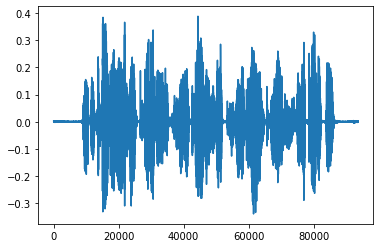

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_data[0][0][0])

As explained in the lecture, waveforms on the computer are stored as discrete representations. Normally, sounds have a contunious representation. The sample rate is how many values we have in these discrete representations per second. Thus, we can calculate the length of the audio in seconds by using the sample rate.

The amount of samples  of the smallest audio in our dataset is calculated by getting the size for each audio within `min()`:

In [ ]:
min([audio[0].shape[1] for audio in train_data])

23120

## Data preprocessing
We start with preprocessing our dataset. We need to get to a representation from the raw audio that a machine learning model can handle. The raw audio only contains time and amplitude, thus we apply fourier transforms on the data to get frequency, then we stack those to get a representation of mel filterbanks.

In [ ]:
stft = torch.stft(train_data[0][0][0], n_fft=400, win_length=200, onesided=True, return_complex=True) 
# First dimension is frequency, second dimension is time
stft.shape

torch.Size([201, 937])

We can calculate a spectrogram by squaring the magnitude of a short-time forier transform. Since we are dealing with complex values, we need to do `abs()` first. We get an "real-valued power spectrogram"

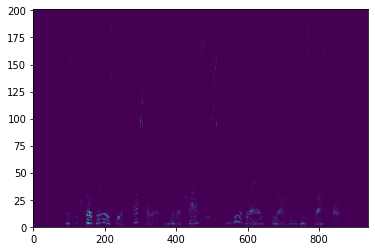

In [ ]:
spectrogram = stft.abs() ** 2
plt.pcolormesh(spectrogram)

This is already a nice spectrogram! Unfortunately we don't see that much. We are currently just plotting the FFT bins against time. Each value of the frequency represents a specific range of Hz. We calculate this by `n * sample_rate / N` where `N = n_fft`. Thus, the first bin is `0 * 16000 / 400 = 0` until `1 * 16000 / 400 = 40`, the second bin is from that until `2 * 16000 / 400 = 80`. We end up with 201 bins, up until a sample rate of 8000, half the nyqvist frequency.

You see that only in the bottom part of the visualisation are values? This is because human speech has a specific frequency. The voiced speech of a typical adult male has a frequency from 85 to 155 Hz, and that of a typical adult female from 165 to 255 Hz.

Now, we can augment the spectrograms to be better in line with our hearing. We need two things for this:
- Mel scale: researchers have found that a different scale would be better suited for plotting spectrograms, instead of linear we have one where with each step we increase the difference 
- Logarithm. By using a logaritmic scale we limit the numerical range, the result is a more closer range to what we humans hear.

We first compute the first one, mel scale. We can do this by getting the filter banks from torchaudio.

In [ ]:

mel_banks = torchaudio.functional.melscale_fbanks(
    spectrogram.shape[0],
    n_mels=80,
    f_min=0.0,
    f_max=16000 / 2.0,
    sample_rate=16000)

We can plot these filter banks. As you can see below, each filter bank represents a different part of the spectrum. The smaller mel banks have a smaller width, thus represent only a few frequencies. In essence: we store more information of the lower Hz values, than the larger Hz values.

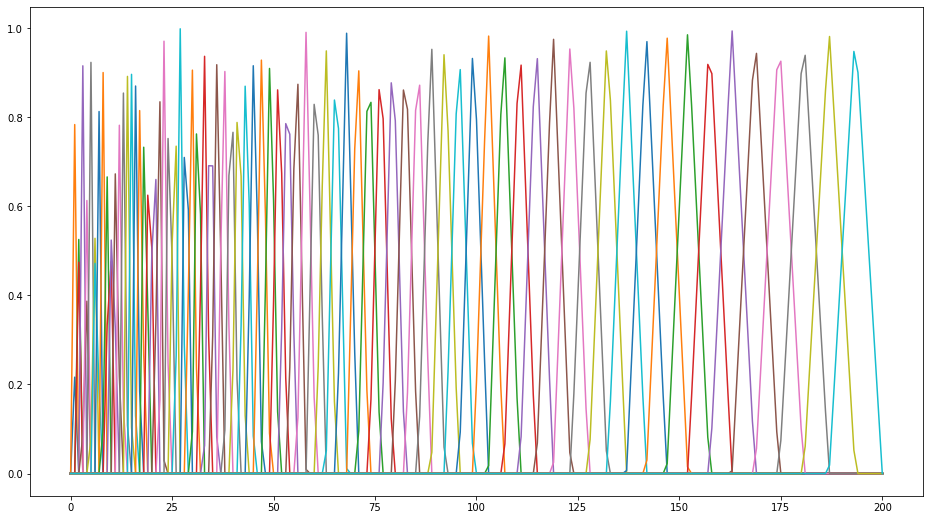

In [ ]:
plt.figure(figsize=[16,9])
plt.plot(mel_banks)
plt.show()

We now only need a simple matrix multiplication to get to a melspectrogram!

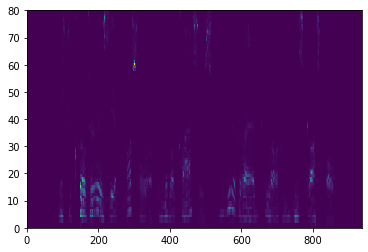

In [ ]:

melspectrogram = mel_banks.T @ spectrogram
plt.pcolormesh(melspectrogram)

### Exercise 1
> Do you see already a difference between a normal spectrogram and the mel spectrogram? What do you notice?

**ANSWER HERE**
frequence's range in the spectogram was 200 and now in the mel is  80.Visualizing smaller range of frequencies over the time,the magnitudes of the frequencies in each time unit are better vissible and clear.People can understand only the significant difference of the loudness of a speach and can not recognize small differences.Thats the idea of the generation of the mel spectogram and the mel scale.

Lastly, we calculate the log of a mel spectrogram, to limit the numerical range. We add a really small value to the mel spectrogram first, since some values of the `melspectrogram` may be 0, and the log of 0 is undefined. 

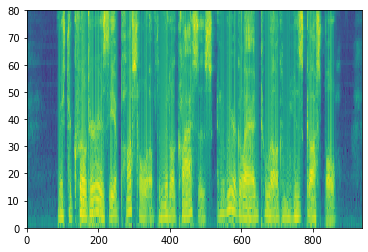

In [ ]:

logmelspectrogram = (melspectrogram + 1e-10).log()
plt.pcolormesh(logmelspectrogram)

## MFCC 
For normal audio classification tasks, the melspectrogram is something we can work with! However, for speech we could even process it even further. We then get MFCC's. MFCC's are a way to represent information about the rate changes in different spectrum bands. Melspectrograms are highly correlated, so we need to decorrelate them with the discrete cosine transform.

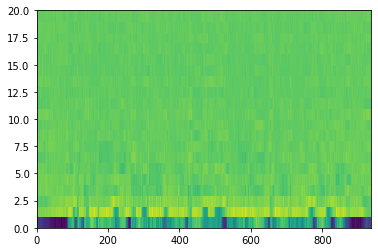

In [ ]:

if logmelspectrogram.ndim == 3:
    logmelspectrogram = logmelspectrogram[0]
dct_matrix = torchaudio.functional.create_dct(n_mfcc=20, n_mels=logmelspectrogram.shape[0], norm="ortho")
mfccs = dct_matrix.T @ logmelspectrogram
plt.pcolormesh(mfccs)

We could also just have used torchaudio.MFCC, instead of all these steps above. See this figure: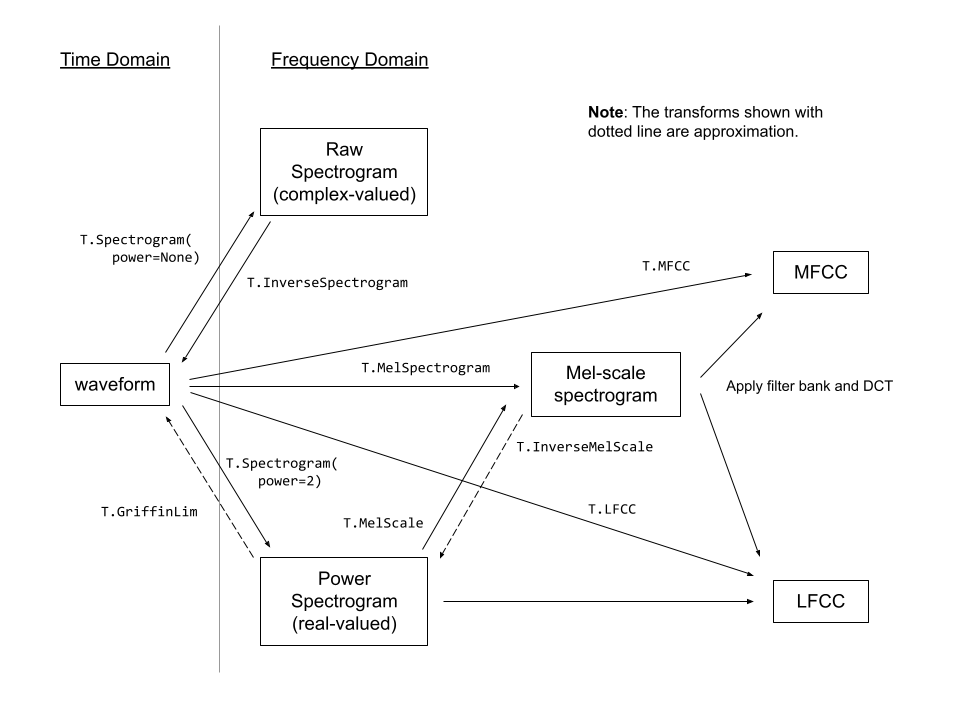

We went waveform to real-valued power spectrogram (below in the figure) to mel-scale spectrogram. We did this to make sure you understand all the steps we take to get to a MFCCC. As you can see, we can directly apply T.MFCC as well. We then do 3 steps in 1.

/usr/local/lib/python3.8/dist-packages/torchaudio/functional/functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (80) may be set too high. Or, the value for `n_freqs` (101) may be set too low.
  warnings.warn(


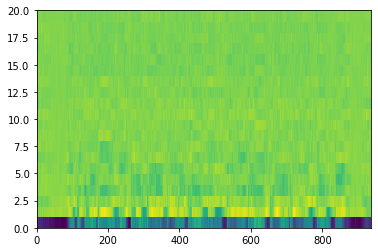

In [ ]:
mfcc_transform = torchaudio.transforms.MFCC(sample_rate=16000, 
                                            n_mfcc = 20,
                                            log_mels = True,
                                            melkwargs={"n_mels":80, "n_fft": 200})
direct_mfccs = mfcc_transform(train_data[0][0][0])
plt.pcolormesh(direct_mfccs)

## RNN
Now we want to train a machine learning model to classify speeches in our dataset right? Lets build a model that can do that for us.
We have one problem: we are dealing with sequential data. This means dat our speeches can vary in length. Thats why we need a sequential model such as an recurrent neural network (RNN) that can have varying lengths as input. At each block in an RNN, we put one audio frame in. With RNNs, we take into account the previous blocks in predicting our current block, so we have a time dependency. 

Lets define a simple RNN in PyTorch. It has the number of mfcc's as input (20, as we defined before) and the number of characters in the alphabet as output (plus a space and a blank character for CTC, total = 28).

In [ ]:

rnn = torch.nn.RNN(20, 28)

In [ ]:

rnn_output, rnn_hidden = rnn(mfccs.T)
rnn_output.shape

torch.Size([937, 28])

## Connectionist Temporal Classification
In the lecture about speech recognition you have heard about connectionist temporal classification (CTC). This builds upon previous knowledge about hidden markov models and beam search.
For a refresher, click [here](https://distill.pub/2017/ctc/).

### Exercise 2
> Which problem does connectionist temporal classification (CTC) solve?

**ANSWER HERE**
Consider speech recognition. We have a dataset of audio clips and corresponding transcripts. Unfortunately, we don’t know how the characters in the transcript align to the audio. This makes training a speech recognizer harder than it might at first seem.Without this alignment, the simple approaches aren’t available to us.
Connectionist Temporal Classification is a way to get around not knowing the alignment between the input and the output.
CTC explicitly learns the monotonic alignment between the
speech feature and character transcription.


We now use CTC to decode the output of our model. We implement CTC ourselves. Lets go over the function below line by line. If you don't understand everything, please debug it by running the functions line by line!

Check the output of `rnn_output.shape` above. We have 937 timesteps. For each timestep, we have 28 options, namely all characters of the alphabet (plus extra characters to help us in splitting tokens up in CTC). At each timestep, we take whatever the model thinks the most probable token is: `argmax()`. 

We then take something essential to CTC: combine consecutive tokens. When we hear multiple A's after each other, they might be combined to the same token. We do this with `unique_consecutive()`.

We skip the blank characters "-", they are used by the model to say we are still dealing with the previous character. In this way, we can have double characters (e.g. pizza would be encoded as piz-za and our `unique_consecutive()` function would not omit the second z). 

We then convert each index to a label by indexing it in our labels list. We defined our label list as all characters of the alphabet plus a space and a blank character (n=28)

In [ ]:
rnn_output

tensor([[ 0.9990,  0.9996, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.9534,  0.9973, -1.0000,  ..., -0.9803, -1.0000, -1.0000],
        [ 0.9705,  0.9993, -1.0000,  ..., -0.9150, -1.0000, -1.0000],
        ...,
        [ 0.4163,  0.9987, -1.0000,  ..., -0.8824, -1.0000, -1.0000],
        [ 0.1568,  0.9975, -1.0000,  ..., -0.9569, -1.0000, -1.0000],
        [ 0.9140,  0.9988, -1.0000,  ..., -0.9920, -1.0000, -1.0000]],
       grad_fn=<SqueezeBackward1>)

In [ ]:
label_list = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", " ", "-"]
blank_index = label_list.index('-')
def ctc_decoder(input_tensor):
    indices = torch.argmax(input_tensor, dim=-1)
    indices = torch.unique_consecutive(indices, dim=-1)
    indices = [i for i in indices if i != blank_index]
    return "".join([label_list[i] for i in indices])

In [ ]:
ctc_decoder(rnn_output)

'MNPWHNHNWPNPNABGANMNMNPFPRPRPNFPFPRNPRPRPRFPFPFSFPFPFPHNPSFPNMNMHMHMHMPURUPHMHNMNMPSPSPGPAPAPSPNMNMNPWPGPSPNMAMPGPUOPUPHNPNHNMHMNWNPNWNPRPRPRPRPRPMNPNARPRSPGGUUPUQPPMPNPSPGPGPNMNMNPHNMHNFNPPGRGAGPUPHNHMNPMPSPSPSPSPAPNM'

And this is our predicted sentence! Right.. Of course it does not represent our correct sentence at all, we only have a really simple RNN and we have not even trained it yet.

In [ ]:
train_data[0][2] # This is our correct sentence

'MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL'

We can train our network using a loss function based off CTC. Then, we can just backpropagate this loss to train our network.
The parameters `input_lengths` and `target_lengths` are there for when we pad our sequences, e.g. to process multiple at once. They make sure the length of the input would be taken account of, the model should ignore the padded values and only focus on the values that are actually the input.

In [ ]:
targets = torch.tensor([label_list.index(c) for c in train_data[0][2]])
ctc_loss = torch.nn.CTCLoss(blank=blank_index)
ctc_loss(rnn_output, 
        targets=targets, 
        input_lengths=torch.tensor(rnn_output.shape[0]),
        target_lengths=torch.tensor(targets.shape[0]),
)

tensor(-10.8588, grad_fn=<MeanBackward0>)

We have this amount of loss to backpropagate in our network! 

---



### Exercise 3
> Define a network with any number of layers using PyTorch, you can use whatever network layers and features (CNN's, LSTM's, Dropout's, etc..). Create a training loop and train your network in multiple epochs on a new dataset, the full train dataset from LibriSpeech, defined below. Use the `CTCLoss` function as training loss for training your network. 

In [ ]:

train_data_full = torchaudio.datasets.LIBRISPEECH(root="./", url="train-clean-100", download=True)

In [ ]:
# Hint:
import string
def collate_fn(batch): 
    labels, mfccs, input_lengths, label_lengths = [], [], [], []
    for (waveform, _, label, _, _, _) in batch:
        mfcc_input = mfcc_transform(waveform[0]).T # Convert to mfccs
        label = label.translate(str.maketrans('', '', string.punctuation)).upper() # Clean transcriptions: remove punctuations
        label = torch.tensor([label_list.index(c) for c in label]) # Convert to integers
        labels.append(label); mfccs.append(mfcc_input)
        input_lengths.append(mfcc_input.shape[0]//2); label_lengths.append(len(label))

    mfccs = torch.nn.utils.rnn.pad_sequence(mfccs,batch_first=True).unsqueeze(1).transpose(2,3) # Pad mfccs to process multiple at once
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True) # Pad labels
    return mfccs, labels, torch.tensor(input_lengths), torch.tensor(label_lengths)
trainloader = torch.utils.data.DataLoader(train_data_full, batch_size=8, collate_fn=collate_fn)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)


In [ ]:
# ANSWER
criterion=ctc_loss
class CNNLayerNorm(nn.Module):
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        x = x.transpose(2, 3).contiguous() 
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() 

class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x
optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
	max_lr=hparams['learning_rate'],
	steps_per_epoch=int(len(train_loader)),
	epochs=hparams['epochs'],
	anneal_strategy='linear')

In [ ]:
def train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter, experiment):
    model.train()
    data_len = len(train_loader.dataset)
    with experiment.train():
        for batch_idx, _data in enumerate(train_loader):
            spectrograms, labels, input_lengths, label_lengths = _data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            optimizer.zero_grad()

            output = model(spectrograms)  
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) 

            loss = criterion(output, labels, input_lengths, label_lengths)
            loss.backward()

            experiment.log_metric('loss', loss.item(), step=iter_meter.get())
            experiment.log_metric('learning_rate', scheduler.get_lr(), step=iter_meter.get())

            optimizer.step()
            scheduler.step()
            iter_meter.step()
            if batch_idx % 100 == 0 or batch_idx == data_len:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(spectrograms), data_len,
                    100. * batch_idx / len(train_loader), loss.item()))
for epoch in range(1, epochs + 1):
        train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter, experiment)
      


In [ ]:
for epoch in range(2):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data ###train_data_full>???
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0


## Evaluating our model
We can evaluate the output of our CTC function by using a bleu score. For the function to work, we need to split our words to a list: each item of the list is a new word:

In [ ]:
candidate = ctc_decoder(rnn_output).split(" ")
reference = test_data[0][2].split(" ")
print(candidate)
print(reference)

['MNPWHNHNWPNPNABGANMNMNPFPRPRPNFPFPRNPRPRPRFPFPFSFPFPFPHNPSFPNMNMHMHMHMPURUPHMHNMNMPSPSPGPAPAPSPNMNMNPWPGPSPNMAMPGPUOPUPHNPNHNMHMNWNPNWNPRPRPRPRPRPMNPNARPRSPGGUUPUQPPMPNPSPGPGPNMNMNPHNMHNFNPPGRGAGPUPHNHMNPMPSPSPSPSPAPNM']
['HE', 'HOPED', 'THERE', 'WOULD', 'BE', 'STEW', 'FOR', 'DINNER', 'TURNIPS', 'AND', 'CARROTS', 'AND', 'BRUISED', 'POTATOES', 'AND', 'FAT', 'MUTTON', 'PIECES', 'TO', 'BE', 'LADLED', 'OUT', 'IN', 'THICK', 'PEPPERED', 'FLOUR', 'FATTENED', 'SAUCE']


In [ ]:
from torchtext.data.metrics import bleu_score
candidate_corpus = [candidate]
references_corpus = [[reference]]
bleu_score(candidate_corpus, references_corpus)

0.0

Thats not really high! Lets see if we can improve that by using a trained model.

### Exercise 4
> Predict for our whole `test_data` dataset its transcript using the **ctc decoder** we defined and evaluate that transcript against its true transcript in the dataset using the **bleu score**.
Try to get a high as possible bleu score using your model you defined at exercise 3 yourself (do not use a pretrained one!)

In [ ]:
# CODE HERE
#try for one audio sentence
stft = torch.stft(test_data[0][0][0], n_fft=400, win_length=200, onesided=True, return_complex=True)
spectrogram = stft.abs() ** 2
mel_banks = torchaudio.functional.melscale_fbanks(
    spectrogram.shape[0],
    n_mels=80,
    f_min=0.0,
    f_max=16000 / 2.0,
    sample_rate=16000)
melspectrogram = mel_banks.T @ spectrogram
logmelspectrogram = (melspectrogram + 1e-10).log()
if logmelspectrogram.ndim == 3:
    logmelspectrogram = logmelspectrogram[0]
dct_matrix = torchaudio.functional.create_dct(n_mfcc=20, n_mels=logmelspectrogram.shape[0], norm="ortho")
mfccs = dct_matrix.T @ logmelspectrogram
#we want the model from exercise 3,not rnn again
rnn = torch.nn.RNN(20, 28)
rnn_output, rnn_hidden = rnn(mfccs.T)
candidate = ctc_decoder(rnn_output).split(" ")
reference = test_data[0][2].split(" ")
candidate_corpus = [candidate]
references_corpus = [[reference]]
bleu_score(candidate_corpus, references_corpus)
#for the whole dataset:
true=[]
for i in range(1,5):
  true.append=test_data[i][2]
bleu_score(true,predicted)

### Exercise 5

> Import a different translation metric than BLEU, that is suited for the task. You can use an external library for this. Use that metric to compute its score of your model between your candidate (predicted) transcripts and the actual transcripts of the **test dataset**. 

In [ ]:
# CODE HERE
#Bleu Score is not the ideal metric for our task.The metric that is typically used for this task is Word Error Rate (WER) or Character Error Rate (CER).
#It compares the predicted output and the target transcript, word by word (or character by character) to figure out the number of differences between them.
metric = WordErrorRate()
metric(preds, target)

### Exercise 6
> Evaluate where the your model still fails to wrongly predict your data. Is it due to noise, talk that is too fast, or just bad data? Or is your model just not good enough? Come up with examples. What would improve the model to even have a higher metric score? What type of model do you think would work better than RNN's and similar ones on this task and dataset (e.g. transformers, CNN's or any other?). Also evaluate what you learned in this tutorial.

**ANSWER HERE**
The model fails to understand the deep meaning/segnment of the audio.The model is just not good enough.
A combination of transformers with cnn's could increase the performance of this task.The combination of transformers with the multi attention head which takes into account the meaning of the content,with the cnn's which can find the allignment of the audio with sentences is a very good model combination.

I learned the following things:
Speech is in the form of waves(waveform).It is depicted as the ampltitude of voice during the time.When ampltitude=0 it means sillence.But we need to transform time to frequency with the fourier transform to undestand better.Frequencies of human speech are mostly betwwen 0 and 1kHZ.Time is lost when we change time to frequencies so we need spectogram which depicts with different colours  the magnitude of frequency on a particular time.Mel spectogram is a better form with a dfferent scale to be more easy for people to understand.
After that,speech turns to an image classification problem.AS i said before a very good model for that is the combination of transformers with CNNs

## Submission 
Please share your Colab notebook by clicking `File` on the top-left corner. Click under `Download` on `Download .ipynb` and upload that file to Canvas.